# 1. Packages

First, I imported all packages that are needed to be used.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from util import *
from logistic_regression import *

%matplotlib inline

# 2. Data

Here, I loaded the dataset.

In [2]:
X, y = load_data("data/processed/dataset_1.csv")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Then, I checked the first few instances of the dataset.

In [3]:
X_train.head(5)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
68,9.029,17.33,58.79,250.5,0.10660,0.14130,0.31300,0.04375,0.2111,0.08046,...,10.31,22.65,65.50,324.7,0.14820,0.43650,1.25200,0.17500,0.4228,0.11750
181,21.090,26.57,142.70,1311.0,0.11410,0.28320,0.24870,0.14960,0.2395,0.07398,...,26.68,33.48,176.50,2089.0,0.14910,0.75840,0.67800,0.29030,0.4098,0.12840
63,9.173,13.86,59.20,260.9,0.07721,0.08751,0.05988,0.02180,0.2341,0.06963,...,10.01,19.23,65.59,310.1,0.09836,0.16780,0.13970,0.05087,0.3282,0.08490
248,10.650,25.22,68.01,347.0,0.09657,0.07234,0.02379,0.01615,0.1897,0.06329,...,12.25,35.19,77.98,455.7,0.14990,0.13980,0.11250,0.06136,0.3409,0.08147
60,10.170,14.88,64.55,311.9,0.11340,0.08061,0.01084,0.01290,0.2743,0.06960,...,11.02,17.45,69.86,368.6,0.12750,0.09866,0.02168,0.02579,0.3557,0.08020


In [4]:
y_train.head(5)

68     0
181    1
63     0
248    0
60     0
Name: class, dtype: int64

After that, I checked the dimensions of the data.

In [5]:
print("The shape of X_train is: ", X_train.shape)
print("The shape of y_train is: ", y_train.shape)

The shape of X_train is:  (455, 30)
The shape of y_train is:  (455,)


# 3. Model

First, I trained my model with the first dataset

In [8]:
my_lr = MyLogisticRegression(0.0001, 10000, 0.0005)
my_lr.fit(X_train, y_train)

Iteration    0: Cost     0.69   
Iteration 1000: Cost     2.43   
Iteration 2000: Cost     3.18   
Iteration 3000: Cost     2.34   
Iteration 4000: Cost     2.57   
Iteration 5000: Cost     7.69   
Iteration 6000: Cost     1.88   
Iteration 7000: Cost     2.02   
Iteration 8000: Cost     2.75   
Iteration 9000: Cost     2.78   
Iteration 9999: Cost     1.94   


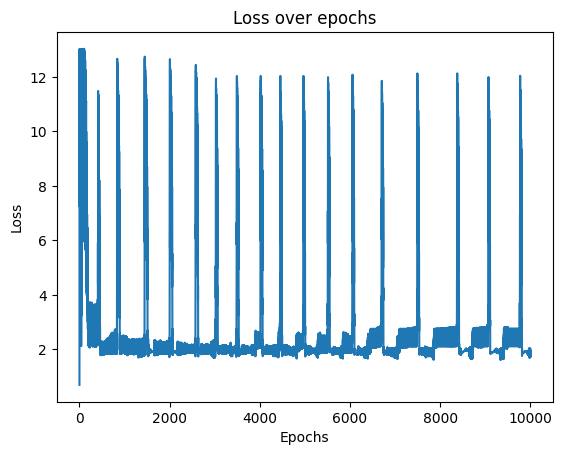

In [9]:
my_lr.plot_loss()

In [10]:
y_pred = my_lr.predict(X_test)
print("The accuracy of my model is: ", accuracy_score(y_test, y_pred))

The accuracy of my model is:  0.9649122807017544


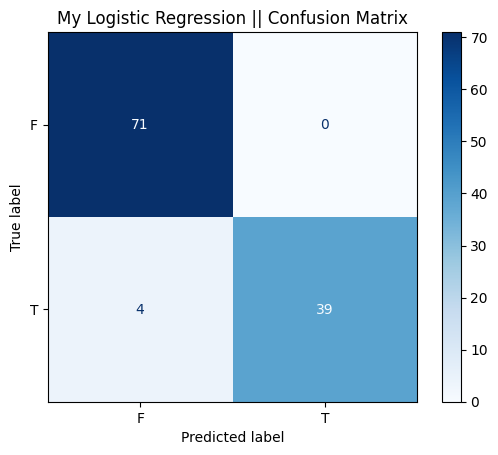

In [17]:
my_cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=my_cm,display_labels=['F','T'])
disp.plot(cmap='Blues')
plt.title('My Logistic Regression || Confusion Matrix')
plt.show()

In [11]:
lr = LogisticRegression(max_iter=10000, tol=0.0005)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("The accuracy of sklearn's model is: ", accuracy_score(y_test, y_pred_lr))

The accuracy of sklearn's model is:  0.956140350877193


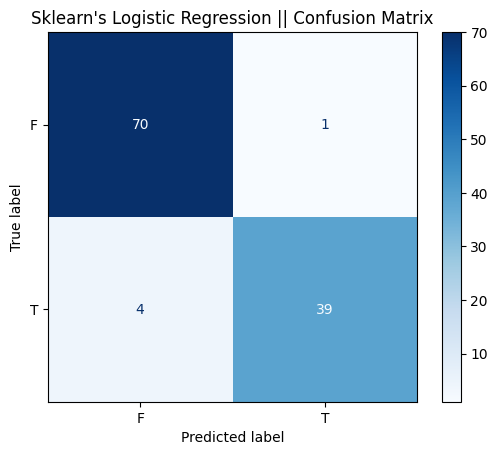

In [18]:
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['F','T'])
disp.plot(cmap='Blues')
plt.title("Sklearn's Logistic Regression || Confusion Matrix")
plt.show()